In [54]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [56]:
len(words)

32033

In [57]:
#Building vocabulary of words and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [58]:
#Building the dataset
block_size = 3 #Context length to specify how many characters we consider to predict the next one

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
    
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] #sliding window
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80%
Xdev, Ydev = build_dataset(words[n1:n2]) #90%
Xte, Yte = build_dataset(words[n2:]) #10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [59]:
n_emb = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_emb), generator=g) #a n_emb-dimensional embedding matrix for each character.
W1 = torch.randn((n_emb * block_size,n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C,W1,W2,b1,b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [60]:
#optimization

max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdims=True)
    # loss2 = -probs[torch.arange(C[X].shape[0]), Y].log().mean()
    # This is nothing but the cross entropy loss
    # Much more efficient to use the pytorch function than do the above

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update params
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000 : 27.8817
  10000/ 200000 : 2.9068
  20000/ 200000 : 2.5306
  30000/ 200000 : 2.8085
  40000/ 200000 : 2.0168
  50000/ 200000 : 2.4266
  60000/ 200000 : 2.4054
  70000/ 200000 : 2.0851
  80000/ 200000 : 2.3674
  90000/ 200000 : 2.3539
 100000/ 200000 : 2.0408
 110000/ 200000 : 2.3113
 120000/ 200000 : 1.9689
 130000/ 200000 : 2.4592
 140000/ 200000 : 2.2833
 150000/ 200000 : 2.1654
 160000/ 200000 : 2.0684
 170000/ 200000 : 1.8238
 180000/ 200000 : 2.0505
 190000/ 200000 : 1.8953


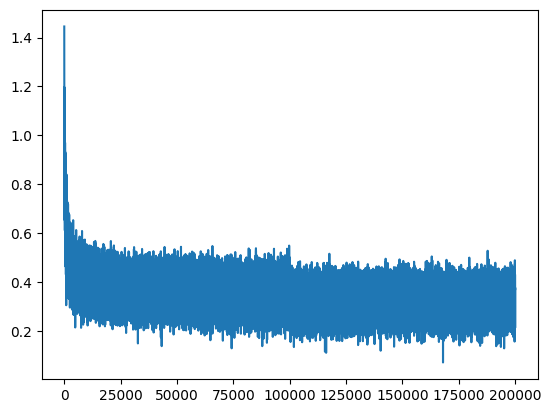

In [61]:
plt.plot(lossi)

In [62]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    } [split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.122990846633911
val 2.1651506423950195


In [65]:
#Sampling from the model

g = torch.Generator().manual_seed(2147)

for i in range(20):
    out = []
    ix = 0
    context_window = [0] * block_size

    while True:
        #do a forward pass
        emb = C[torch.tensor([context_window])]
        embcat = emb.view(1, n_emb * block_size)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #probs is the distribution after passing the context window
        #Sample from this distribution and then update the context window
        #Keep continuing until we draw a '.' which means the word is over
        
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()

        out.append(ix)
        context_window = context_window[1:] + [ix]

        if ix==0:
            break


    print(''.join(itos[i] for i in out))
    
    



kaylynn.
taviy.
prie.
hensyn.
caspyn.
cee.
mckingsnabella.
jouria.
sanan.
sen.
kyelo.
liwan.
aze.
lakiance.
sahilden.
jasn.
kmisa.
abreisheinachilynn.
adlanim.
armanda.


In [ ]:
#The names are now much more name-like than the bigram model but there is still room for imporvement.